# TAOS2: clean ship data

**taos2-drifters0:** 
Manually concatenate `ship_hydrophone_05052023_a`, `ship_hydrophone_05052023_b`, `ship_hydrophone_05052023_c`.

**taos2-drifters1:** ...

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

In [70]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos2-drifters0
campaign="taos2_drifters0"
yaml = f"drifters0/{campaign}.yaml"
ships = ["hydrophone", "delphy"]

# taos2-drifters1
#campaign="taos2_drifters1"
#yaml = f"drifters2/{campaign}.yaml"
#ships = ["delphy"]

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

d0 drifter0 None d0 / start 2022-11-14 11:50:23 -0.26 49.35 / end 2022-12-16 10:34:10 0.42 50.11
d0 drifter1 None d0 / start 2022-11-14 12:06:00 -0.26 49.33 / end 2022-11-17 17:02:35 0.02 49.50
d0 drifter2 None d0 / start 2022-11-14 12:11:30 -0.24 49.34 / end 2022-11-18 11:11:35 -0.17 49.69
d0 hydrophone None d0 / start 2023-05-05 07:55:00 / end 2023-05-05 11:23:00
d1 hydrophone None d1 / start 2023-05-09 09:16:00 / end 2023-05-09 13:31:00
d2 hydrophone None d2 / start 2023-05-11 10:32:00 / end 2023-05-11 13:35:00
cast0 hydrophone ctd cast0 / start 2022-11-14 12:34:50 -0.24 49.34 / end 2022-11-14 12:36:00 -0.24 49.34
d0 delphy None d0 / start 2023-05-05 07:24:00 / end 2023-05-05 11:39:00
d1 delphy None d1 / start 2023-05-09 09:40:00 / end 2023-05-09 14:00:00
cast0 delphy ctd cast0 / start 2022-11-14 14:20:50 -0.39 49.43 / end 2022-11-14 14:23:43 -0.39 49.43


---

## ships


In [74]:
# search for deployments
s = ships[0]
s = ships[1]

deployments = list(cp[s]["deployments"])

# select a deployment to process
d = deployments[0] # d0
d = deployments[1] # d1
#d = deployments[2] # d2

print(f"processing ship {s}")
print("Available deployments: "+" / ".join(deployments))
print(f"Working with deployment {d} here")

# need to manually set correct day
#cday = dict(year=2022, month=5, day=11)
cday = cp[s][d].start.time.round("1D").tz_localize("UTC")

# load data
D = dict()
#for s in ships:
#    if d in cp[s]["deployments"]:
file = os.path.join(cp["path_raw"], cp[s][d]["file"])
D[s] = se.read_lern_ship(file, correct_day=cday)

processing ship delphy
Available deployments: d0 / d1
Working with deployment d1 here
columns:
['ï»¿ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']
Fix first time from 2023-05-09 09:39:20+00:00 to 2023-05-09 09:39:20+00:00


In [75]:
#s = "hydrophone"
#if s in ships:
D[s].geo.plot_bokeh(deployments=cp[s][d]) #
D[s].geo.plot_on_map()

Loading BokehJS ...

(:Overlay
    .Tiles.I  :Tiles   [x,y]
    .Points.I :Points   [longitude,latitude]   (time),
 {'x': 'longitude', 'y': 'latitude', 'geo': True})

### store

In [76]:
# store
#for s in ships:
df = D[s].ts.trim(cp[s][d])
(df.to_xarray()
 .to_netcdf(os.path.join(cp["path_processed"], f'{s}_{d}.nc'), mode="w")
)
df.head()

,longitude,latitude,water_depth,air_temperature
time,,,,
2023-05-09 09:41:11,-0.099182,49.292942,4.506771,0.0
2023-05-09 09:41:12,-0.099174,49.292945,4.245853,0.0
2023-05-09 09:41:14,-0.099154,49.292952,3.866333,0.0
2023-05-09 09:41:17,-0.099135,49.292962,4.198414,0.0
2023-05-09 09:41:20,-0.099136,49.292970,5.052326,0.0


### other plots

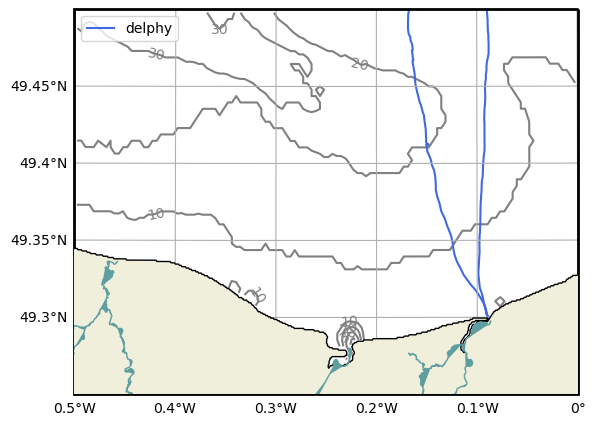

In [77]:
bounds=[-.5, -.1, 49.25, 49.5]
#bounds=[-.5, .0, 49.25, 49.5]
fig, ax, cbar = cp.map(extent=bounds)

#for s in ships:
ax.plot(D[s].longitude, D[s].latitude, transform=crs, label=s, color=cp[s]["color"],)

ax.legend()

### Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 0, '[s]')

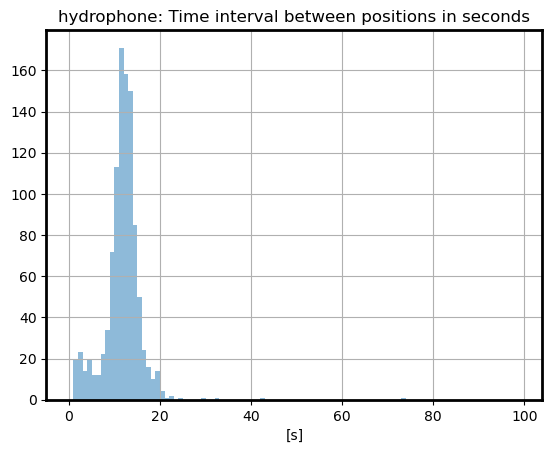

In [46]:
#for s in ships:

_df = D[s].reset_index()
_df["dt"] = _df["time"].diff()/pd.Timedelta("1s")
_df["dt"].hist(bins=np.arange(0,100,1), alpha=0.5)
plt.title(s+": Time interval between positions in seconds")
plt.xlabel("[s]")